### Regression - Gradient Boosting Regression Tree
In this part, we will apply regression algorithm to predict the special weather. This script show how gradient boosting regression tree works and we will evaluate our work by standard deviation.

#### Take a sample from the whole data set

In [43]:
import random

f = open('data_with_location.csv')
fin = open('data_narrow.csv','w')

for each in f:
    i = random.random()
    if i < 0.01:
        fin.write(each)

f.close()
fin.close()



### Helper functions
There are some helper functions to extract features from the raw data set.

In [44]:
import collections
import pandas as pd
import sklearn.utils as utils

# Convert raw data location format
# For the latitude and logitude, E,N will be positive while W,S will be negative
def getLocation(loc):
    rs = [0,0]
    
    la = loc[0]
    lo = loc[1]
    
    end_la = la[-1]
    end_lo = lo[-1]
    
    l1 = len(la)
    l2 = len(lo)
    
    la = la[0:l1-1]
    lo = lo[0: l2-1]
    
    if end_la == 'N':
        rs[0] = float(la) / 100.0
    else:
        rs[0] = float(la) / -100.0
    
    if end_lo == 'E':
        rs[1] = float(lo) / 100.0
    else:
        rs[1] = float(lo) / -100.0
    return rs    
 

# Some of the data may contains one bit flag like '*,A,I' and so on
# This method will pop this value if it contains one bit tag
def extractNumber(s):
    last = s[-1]
    l = len(s)
    if ord(last) >= ord('0') and ord(last) <= ord('9'):
        return s
    else:
        return s[0:l-1]


# @weather_str 6-bits string. 
# @in_detail if True, return lables from 0 to 63. If False, return boolean labels
def getSpecialWeatherLabel(weather_str, in_detail = False):
    
    label = 0
    for x in range(6):
        weight = 1 << x
        v = int(weather_str[x])
        label += weight*v
    
    if in_detail:
        return label
    else:
        return label == 0
        

# For each row in the file, get its features and labels
# @filepath input data file path
# @return type: pandas.DataFrame
def extractClassificationTable(filepath, in_detail = False):
    f = open(filepath)
    
    fdict = collections.defaultdict(list)
    
    names = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 
             'GUST', 'MAX', 'MIN', 'SNDP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 
             'THUNDER', 'TORNADO']
    for each in f:
        data = each.strip().split(',')
        #get month
        month = data[2][4:6]
        month = int(month)
        
        fdict['MONTH'].append(month)
        
        i = 0
        for x in xrange(3, 17, 2):
            fdict[names[i]].append(float(data[x]))
            i+=1
        fdict['GUST'].append(float(data[16]))
        
        maxV = extractNumber(data[17])
        minV = extractNumber(data[18])
        
        
        fdict['MAX'].append(float(maxV))
        fdict['MIN'].append(float(minV))
        fdict['SNDP'].append(float(data[20]))
        fdict['LABEL'].append(getSpecialWeatherLabel(data[21], in_detail))
        
        lati, logi = getLocation([data[-2],data[-1]])
        fdict['LAT'].append(lati)
        fdict['LOG'].append(logi)
    
    frame = pd.DataFrame(fdict)
    
    return frame

### Build standard feature vectors and labels
First I get all features and then I pop the last column which is the label.

In [45]:
classify_dataframe = extractClassificationTable('data_narrow.csv', True)
weather_labels  =classify_dataframe.pop('LABEL')
print classify_dataframe.shape
print classify_dataframe.head(2)
print classify_dataframe.columns

(23251, 14)
   DEWP   GUST    LAT  LOG   MAX   MIN  MONTH  MXSPD     SLP   SNDP     STP  \
0  17.1  999.9  70.56 -8.4  27.1  18.7      3   27.2  1012.7  999.9  1011.5   
1  15.1  999.9  70.56 -8.4  22.3  17.4      4   23.3  1011.3  999.9  1010.1   

   TEMP  VISIB  WDSP  
0  23.7   19.3  16.8  
1  20.0    7.1  15.1  
Index([u'DEWP', u'GUST', u'LAT', u'LOG', u'MAX', u'MIN', u'MONTH', u'MXSPD',
       u'SLP', u'SNDP', u'STP', u'TEMP', u'VISIB', u'WDSP'],
      dtype='object')


### Build train and test data set
First I randomly take N samples from the raw data set and the rest becomes the test data set.

In [46]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


y = weather_labels.values
X = classify_dataframe.values

X, y = utils.shuffle(X, y, random_state=1)
print X.shape
print y.shape
print y
train_set_size = 5000
X_train = X[:train_set_size]  # selects first 10000 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 10000 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

(23251L, 14L)
(23251L,)
[ 0  2 18 ...,  0  0  2]
(5000L, 14L) (5000L,)
(18251L, 14L) (18251L,)


### Evaluation
We use mean squared error(MSE) to evaluate our model. 
$$MSE = \frac{1}{n}\sum^{n}_{i=1}(\hat{Y} - Y_i)^2$$

In [47]:
from sklearn import ensemble


params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
gbrt = ensemble.GradientBoostingRegressor(**params)
gbrt = gbrt.fit(X_train,y_train)

mse = mean_squared_error(y_test, gbrt.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 15.1191


### Analysis
Here we focus on the over fitting. To visualization this problem, we take two steps:
+ for each different number of estimators, we get the score.
+ plot these score on one graph

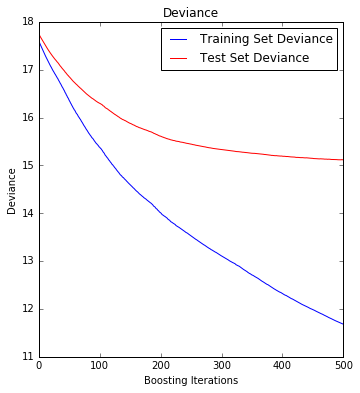

In [48]:
%matplotlib inline
clf = gbrt

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Here we find that, when the number of estimator grows, the deviance decrease quickly. Because when we increase the estimator, the result fits deeper on the train data set. But when the estimator continue growing, for example, in the graph from 300 to 500. The deviance on train data set goes down quickly while test data set deviance almost remain the same. In that case we find the case for over fitting.